# Ultrasound breast imaging with Forge

In this notebook we solve the inverse problem, using full-waveform inversion to reconstruct an acoustic velocity model.

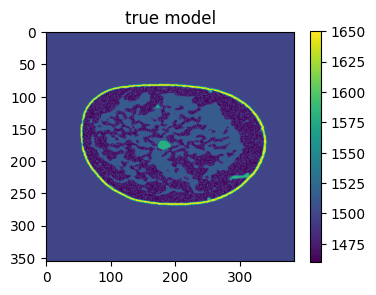

In [1]:
import numpy as np

# load the 2D anastasio breast model and set a water starting model
m = np.load('./data/anastasio2D.npy')
m0 = np.empty_like(m)
m0[:,:] = 1500

import matplotlib.pyplot as plt

# plot the true model
plt.figure(figsize=(4,3))
plt.imshow(m)
plt.title('true model')
plt.colorbar()
plt.show()

In [2]:
# load the transducer geometry
r_geometry = np.load('./data/geometry.npy')
s_geometry = r_geometry.copy()

In [3]:
from forge.utils import interpolate_models

frequency = 5e5

# interpolate models to required grid-spacing dxi
dxi, mi, m0i, r_posi, s_posi, _, _ = interpolate_models(m, m0, r_geometry, s_geometry, dx=5e-4, frequency=frequency)

# set the temporal increment, dt, to be small enough to meet the CFL condition for numerical stability
courant = 0.61
dt = (courant*dxi)/max(mi.max(), m0i.max())

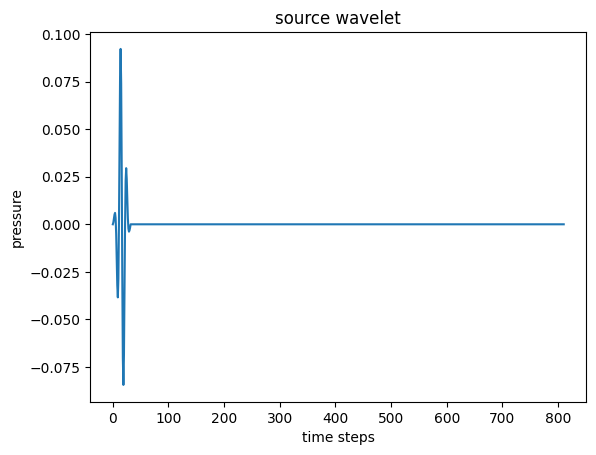

In [4]:
from forge.utils import tone_burst

time = 0.00015

# define the source wavelet 
source = tone_burst(dt, centre_freq=frequency, n_cycles=3, n_samples=round(time/dt), amplitude=1e-1, plot=True)

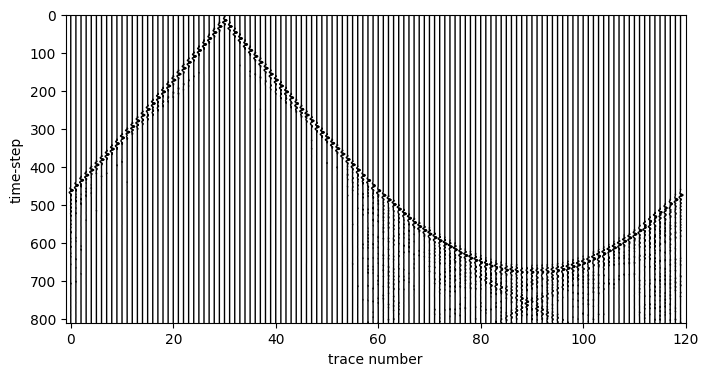

In [5]:
import torch

# load the forward modelled data
d = torch.from_numpy(np.load('./data/d.npy'))

from forge.utils import trace_plot, trace_normalize

# visualize traces of true modelled data
trace_plot(trace_normalize(d), 30)

In [6]:
from forge.main import WaveInversion

# instantiate a new Forge WaveformInversion_2d class for the inversion
model = WaveInversion(model = m0i, # starting model
                      dx = dxi, # spatial increment
                      dt = dt, # temporal increment
                      r_pos = r_posi,
                      sampling_rate = 7) # receiver positions

device = cuda:0


In [7]:
# define a stochastic gradient descent optimizer with momentum
opt = torch.optim.SGD([model.m], lr=1e-5, momentum=0.4)

from forge.utils import shot_normalize

# define a standard shot-normalized L2 loss function 
def l2_loss(input, target):
    return torch.norm(shot_normalize(input) - shot_normalize(target))**2

In [8]:
# invert the data with .fit()
model.fit(data = d, # truedata
          s_pos = s_posi, # source locations as indices
          source = source, # source wavelet
          optimizer = opt, # optimizer
          loss = l2_loss, # loss function
          num_iter = 6, # number of iterations per frequency block
          bs = 15, # batch size/number of sources per forward run
          blocks = [3e5, 4e5], # multi-scale frequency blocks
          box = (mi.min(), mi.max()), # box constraints
          true_model = mi) # true model for reporting inversion RMSE

block 1/2 | 3e+05Hz
  iteration 1/6


100%|████████████████████| 811/811 [00:02<00:00, 270.55it/s]


    loss = 9.79e-08
    rmse = 0.0001467
  iteration 2/6


100%|████████████████████| 811/811 [00:02<00:00, 273.74it/s]


    loss = 7.12e-08
    rmse = 0.0001349
  iteration 3/6


100%|████████████████████| 811/811 [00:02<00:00, 270.39it/s]


    loss = 1.091e-07
    rmse = 0.0001287
  iteration 4/6


100%|████████████████████| 811/811 [00:02<00:00, 275.49it/s]


    loss = 1.761e-07
    rmse = 0.0001194
  iteration 5/6


100%|████████████████████| 811/811 [00:02<00:00, 273.55it/s]


    loss = 5.629e-08
    rmse = 0.0001156
  iteration 6/6


100%|████████████████████| 811/811 [00:02<00:00, 276.09it/s]


    loss = 1.128e-07
    rmse = 0.0001086
______________________________________________________________________ 

block 2/2 | 4e+05Hz
  iteration 1/6


100%|████████████████████| 811/811 [00:02<00:00, 277.23it/s]


    loss = 1.81e-07
    rmse = 0.000105
  iteration 2/6


100%|████████████████████| 811/811 [00:02<00:00, 270.69it/s]


    loss = 8.907e-08
    rmse = 0.0001048
  iteration 3/6


100%|████████████████████| 811/811 [00:02<00:00, 272.45it/s]


    loss = 1.139e-07
    rmse = 0.0001006
  iteration 4/6


100%|████████████████████| 811/811 [00:02<00:00, 270.72it/s]


    loss = 4.168e-08
    rmse = 9.864e-05
  iteration 5/6


100%|████████████████████| 811/811 [00:02<00:00, 274.71it/s]


    loss = 4.848e-08
    rmse = 9.525e-05
  iteration 6/6


100%|████████████████████| 811/811 [00:02<00:00, 274.47it/s]

    loss = 1.038e-07
    rmse = 9.342e-05
______________________________________________________________________ 



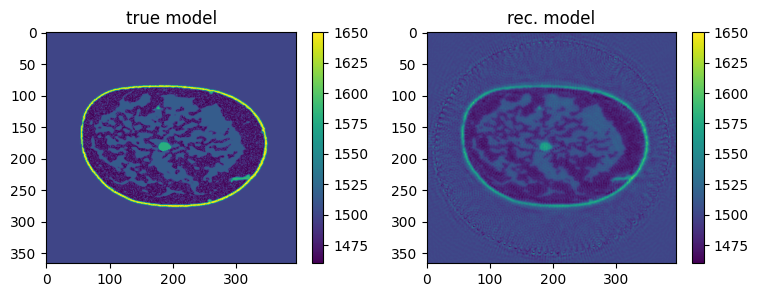

In [9]:
# compare the true vs the FWI recovered model
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.imshow(mi, vmin=mi.min(), vmax=mi.max())
plt.title('true model')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(model.m_out(), vmin=mi.min(), vmax=mi.max())
plt.title('rec. model')
plt.colorbar()
plt.show()